In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import numpy as np
from sklearn.utils import shuffle

Hàm tạo dataset của chị Tuyết 

"Tại đây"


In [2]:
def get_dataset_path(file_name):
    base_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
    dataset_dir = os.path.abspath(os.path.join(base_dir, "..", "datasets"))
    return os.path.join(dataset_dir, file_name)


def load_and_preprocess_dataset(file_name, label_column='label'):
    df = pd.read_csv(get_dataset_path(file_name))
    # Sử dụng ascii hoặc loại bỏ ký tự unicode khi in ra terminal
    print("Du lieu ban dau:", df.shape)

    # Xử lý missing value (giản lược: loại bỏ các dòng thiếu)
    df = df.dropna()

    # Encode các cột object (bao gồm nhãn nếu cần)
    encoders = {}
    for col in df.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

    X = df.drop(columns=[label_column])
    y = df[label_column]
    return X, y, df, encoders


def prepare_all_splits(X, y, train_ratios=[40, 60, 80, 90]):
    """
    Chuẩn bị các tập train/test với các tỷ lệ khác nhau, shuffle và stratify.
    Trả về dict chứa các tập và nhãn gốc.
    """
    # Shuffle trước khi chia
    X_shuffled, y_shuffled = shuffle(X, y, random_state=42)
    splits = {}
    for ratio in train_ratios:
        train_size = ratio / 100
        X_train, X_test, y_train, y_test = train_test_split(
            X_shuffled, y_shuffled,
            train_size=train_size,
            stratify=y_shuffled,
            random_state=42,
            shuffle=True
        )
        splits[ratio] = {
            'feature_train': X_train,
            'label_train': y_train,
            'feature_test': X_test,
            'label_test': y_test
        }
        # Tạo biến toàn cục cho từng tập
        globals()[f"feature_train_{ratio}"] = X_train
        globals()[f"label_train_{ratio}"] = y_train
        globals()[f"feature_test_{100-ratio}"] = X_test
        globals()[f"label_test_{100-ratio}"] = y_test
    return splits, y_shuffled


def plot_class_distributions(original_labels, splits, save=False):
    """
    Vẽ biểu đồ phân phối nhãn cho tập gốc, train, test của từng tỷ lệ.
    """
    ratios = list(splits.keys())
    num_plots = 1 + 2 * len(ratios)
    rows = (num_plots + 2) // 3
    plt.figure(figsize=(15, rows * 4))

    # Plot original distribution
    plt.subplot(rows, 3, 1)
    sns.countplot(x=original_labels)
    plt.title("Original Dataset")

    plot_index = 2
    for ratio in ratios:
        train_labels = splits[ratio]['label_train']
        test_labels = splits[ratio]['label_test']

        plt.subplot(rows, 3, plot_index)
        sns.countplot(x=train_labels)
        plt.title(f"Train ({ratio}%)")
        plot_index += 1

        plt.subplot(rows, 3, plot_index)
        sns.countplot(x=test_labels)
        plt.title(f"Test ({100 - ratio}%)")
        plot_index += 1

    plt.tight_layout()
    if save:
        plt.savefig("class_distributions.png")
    plt.show()


Du lieu ban dau: (303, 14)
Shape X: (303, 13) Shape y: (303,)


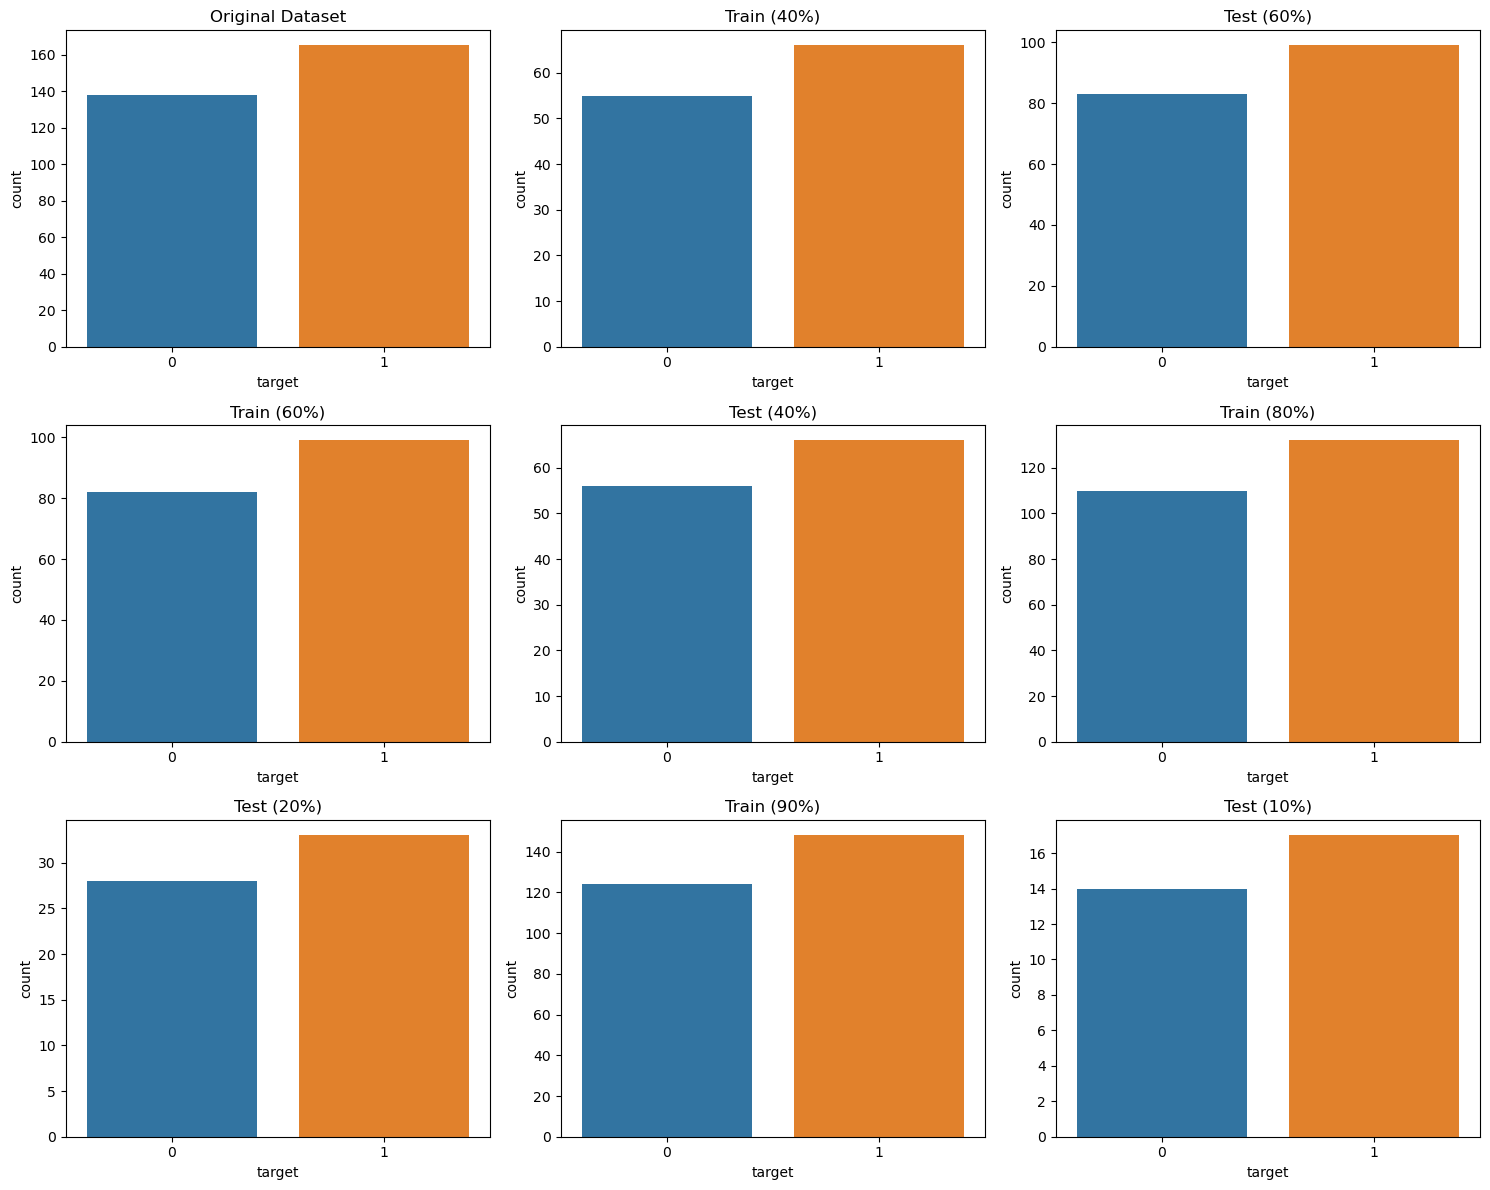

Du lieu ban dau: (344, 9)
Shape X2: (333, 8) Shape y2: (333,)


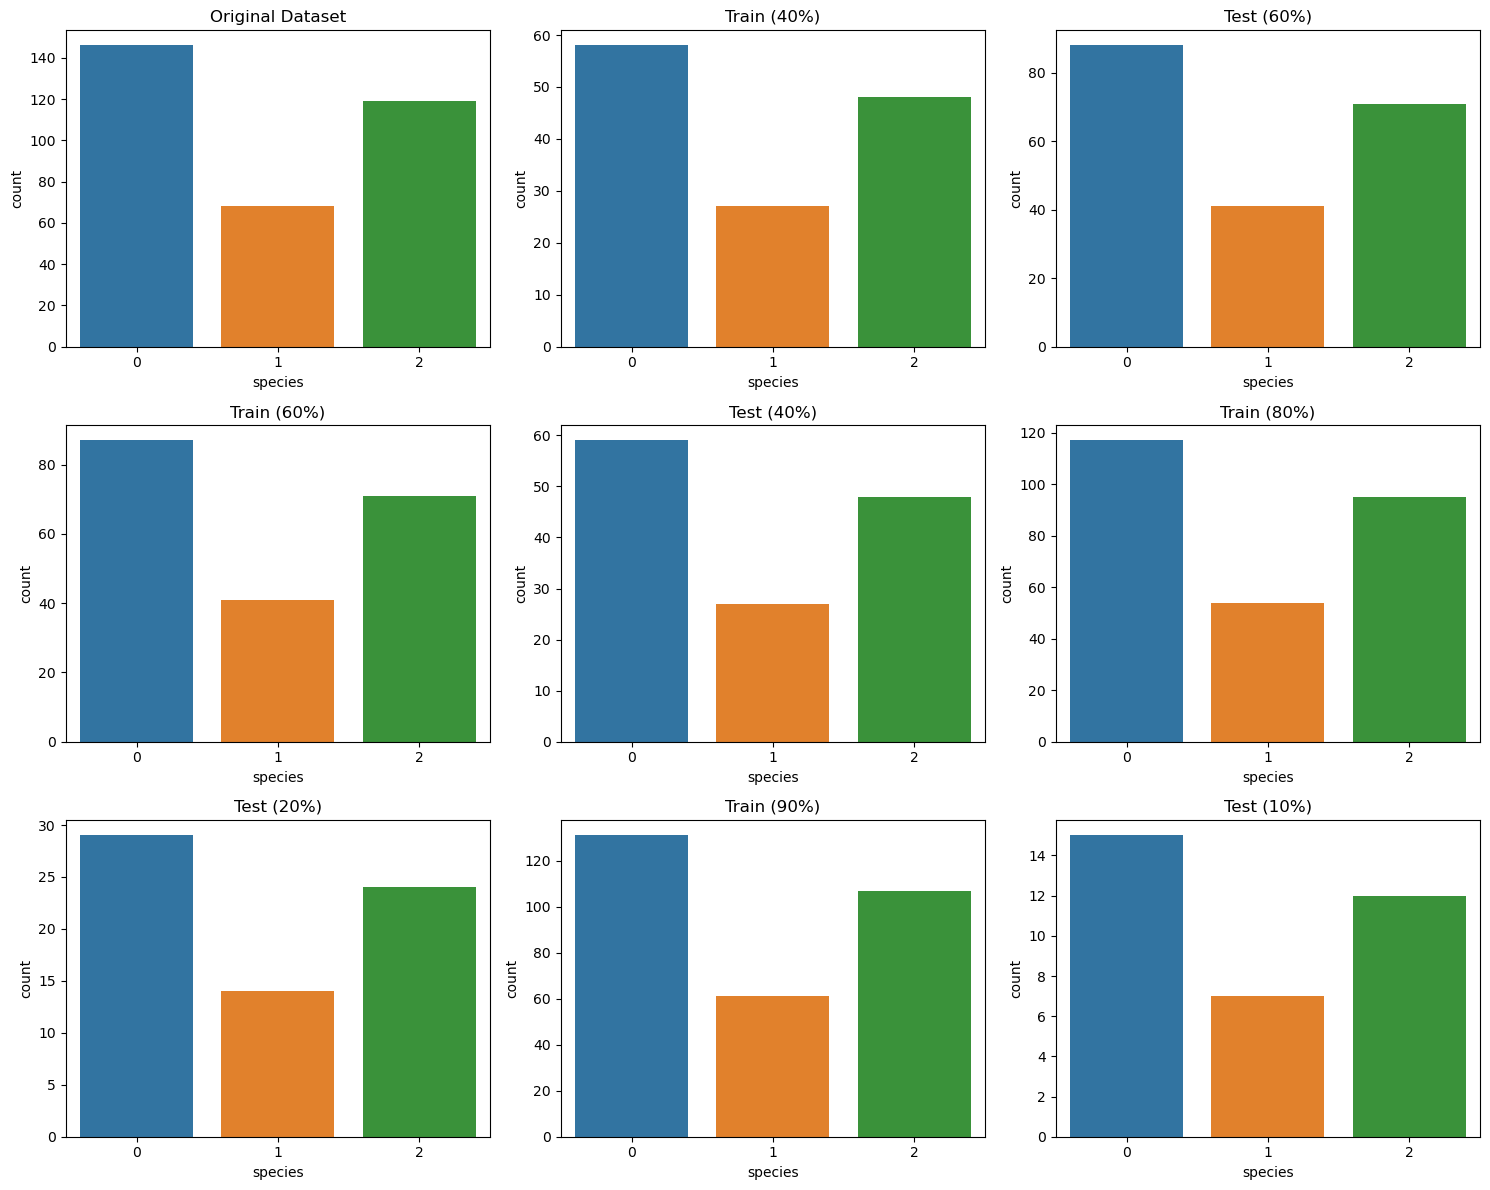

In [3]:
#heart_disease
X, y, df, encoders = load_and_preprocess_dataset("heart_disease.csv", label_column="target")
print("Shape X:", X.shape, "Shape y:", y.shape)
splits, y_shuffled = prepare_all_splits(X, y)
plot_class_distributions(y_shuffled, splits)

#palmer_penguins
X2, y2, df2, encoders2 = load_and_preprocess_dataset("palmer_penguins.csv", label_column="species")
print("Shape X2:", X2.shape, "Shape y2:", y2.shape)
splits2, y2_shuffled = prepare_all_splits(X2, y2)
plot_class_distributions(y2_shuffled, splits2)

Bài của Thiện

1. Huấn luyện với từng tỷ lệ chia: 40/60, 60/40, 80/20, 90/10

In [9]:
import os
from sklearn.tree import DecisionTreeClassifier
import pickle

def train_and_save_decision_trees(data_splits, proportions, seed=42):
    """
    Train decision tree models for various data splits and save them to disk.

    Parameters:
        data_splits (list): List of tuples with (X_train, X_test, y_train, y_test).
        proportions (list): List of tuples with (train_ratio, test_ratio).
        seed (int, optional): Seed for reproducibility. Defaults to 42.

    Returns:
        list: Collection of trained decision tree models.
    """
    # Create directory for saving models if it doesn't exist
    save_dir = "decision_trees"
    os.makedirs(save_dir, exist_ok=True)

    # Initialize list to store trained models
    trained_trees = []

    # Process each data split and proportion
    for idx, (data, ratio) in enumerate(zip(data_splits, proportions)):
        train_features, _, train_labels, _ = data
        train_ratio, test_ratio = ratio

        # Configure and train decision tree
        tree = DecisionTreeClassifier(
            criterion="entropy",
            splitter="best",
            random_state=seed
        )
        tree.fit(train_features, train_labels)

        # Store trained model
        trained_trees.append(tree)

        # Generate filename based on split ratios
        file_path = os.path.join(save_dir, f"dt_model_{int(train_ratio*100)}_{int(test_ratio*100)}.pkl")

        # Save model to disk
        with open(file_path, 'wb') as f:
            pickle.dump(tree, f)

        # Print confirmation
        print(f"Model for {int(train_ratio*100)}:{int(test_ratio*100)} split trained and saved to {file_path}")

    return trained_trees

2. Hình dung cây quyết định với các tỷ lệ phân chia khác nhau

In [8]:
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import display
import os

def plot_decision_trees(models, depths, feature_labels, class_labels):
    """
    Generate visualizations for decision tree models and save them as PNG files.

    Parameters:
        models (list): List of trained DecisionTreeClassifier instances.
        depths (list): List of integers specifying max depths for each model.
        feature_labels (list): Names of features used in the models.
        class_labels (list): Names of target classes in the dataset.
    """
    # Define output directory
    output_dir = "trees_visualization"
    os.makedirs(output_dir, exist_ok=True)

    # Process each model and depth
    for idx, (tree_model, depth) in enumerate(zip(models, depths)):
        # Generate dot format for the tree
        tree_dot = export_graphviz(
            tree_model,
            feature_names=feature_labels,
            class_names=class_labels,
            filled=True,
            rounded=True,
            special_characters=True
        )

        # Create Graphviz object
        tree_graph = graphviz.Source(tree_dot, format="png")
        tree_graph.engine = "dot"

        # Define file path for saving
        file_name = f"{output_dir}/tree_split_80_20_depth_{depth}.png"
        
        # Save the visualization
        tree_graph.render(filename=file_name, cleanup=True)

        # Display in interactive environment
        display(tree_graph)

        # Print status message
        print(f"Tree with depth {depth} for 80:20 split visualized and saved as {file_name}")

In [10]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def assess_decision_trees(models, data_splits, ratios):
    """
    Assess trained decision tree models by generating classification reports and confusion matrix heatmaps.

    Parameters:
        models (list): List of trained decision tree models.
        data_splits (list): List of tuples containing (X_train, X_test, y_train, y_test).
        ratios (list): List of tuples with (train_ratio, test_ratio).

    Returns:
        None: Saves classification reports and confusion matrix heatmaps as PNG files.
    """
    # Create output directory
    output_dir = "evaluation_reports"
    os.makedirs(output_dir, exist_ok=True)

    # Process each model, dataset, and ratio
    for idx, (model, data, (train_ratio, test_ratio)) in enumerate(zip(models, data_splits, ratios)):
        _, test_features, _, test_labels = data

        # Generate predictions
        predictions = model.predict(test_features)

        # Compute classification report as a dictionary
        report_dict = classification_report(test_labels, predictions, zero_division=1, digits=4, output_dict=True)

        # Compute confusion matrix
        cm = confusion_matrix(test_labels, predictions)

        # Create figure with two subplots
        fig = plt.figure(figsize=(14, 7))

        # Subplot 1: Classification report as a single table
        ax1 = fig.add_subplot(121)
        table_data = []
        table_rows = []

        # Extract class metrics
        for label in report_dict:
            if label not in ['accuracy', 'macro avg', 'weighted avg']:
                table_data.append([
                    report_dict[label]['precision'],
                    report_dict[label]['recall'],
                    report_dict[label]['f1-score'],
                    report_dict[label]['support']
                ])
                table_rows.append(label)
        
        # Add accuracy, macro avg, weighted avg
        table_data.append([None, None, report_dict['accuracy'], None])
        table_rows.append('accuracy')
        for avg in ['macro avg', 'weighted avg']:
            table_data.append([
                report_dict[avg]['precision'],
                report_dict[avg]['recall'],
                report_dict[avg]['f1-score'],
                report_dict[avg]['support']
            ])
            table_rows.append(avg)

        # Create table
        table = ax1.table(
            cellText=[[f"{x:.4f}" if isinstance(x, float) else x or "" for x in row] for row in table_data],
            colLabels=['Precision', 'Recall', 'F1-Score', 'Support'],
            rowLabels=table_rows,
            loc='center',
            cellLoc='center',
            colWidths=[0.2, 0.2, 0.2, 0.2],
            bbox=[0.1, 0.1, 0.8, 0.8]
        )
        table.set_fontsize(10)
        for (i, j), cell in table.get_celld().items():
            cell.set_height(0.08)
            cell.set_text_props(ha='center', va='center')
        ax1.axis('off')
        ax1.set_title('Classification Metrics')

        # Subplot 2: Confusion matrix heatmap
        ax2 = fig.add_subplot(122)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='viridis',
            cbar=True,
            xticklabels=model.classes_,
            yticklabels=model.classes_,
            square=True
        )
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('Actual')
        ax2.set_title('Confusion Matrix')

        # Set figure title
        fig.suptitle(f'Evaluation for {int(train_ratio*100)}:{int(test_ratio*100)} Split', fontsize=14)

        # Save figure
        file_path = os.path.join(output_dir, f'eval_report_{int(train_ratio*100)}_{int(test_ratio*100)}.png')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(file_path)
        plt.show()

        # Print confirmation
        print(f"Evaluation for {int(train_ratio*100)}:{int(test_ratio*100)} split saved to {file_path}")

In [11]:
import os
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def train_depth_varied_trees(data_split, depth_values):
    """
    Train decision tree models with varying max depths and compute their test accuracies.

    Parameters:
        data_split (tuple): Tuple containing (X_train, X_test, y_train, y_test).
        depth_values (list): List of max depth values (integers or None) for training models.

    Returns:
        tuple: (list of trained models, dictionary mapping max depths to test accuracies)
    """
    # Create directory for saving models
    save_dir = "decision_trees/depth_models"
    os.makedirs(save_dir, exist_ok=True)

    # Initialize lists and dictionaries
    trained_trees = []
    accuracy_map = {}

    # Extract data
    X_train, X_test, y_train, y_test = data_split

    # Train models for each max depth
    for depth in depth_values:
        # Configure decision tree
        tree = DecisionTreeClassifier(
            criterion="entropy",
            max_depth=depth,
            random_state=42
        )

        # Train model
        tree.fit(X_train, y_train)

        # Store model
        trained_trees.append(tree)

        # Compute accuracy
        predictions = tree.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_map[depth] = accuracy

        # Save model
        depth_str = str(depth) if depth is not None else "none"
        file_path = os.path.join(save_dir, f"tree_depth_{depth_str}.pkl")
        with open(file_path, 'wb') as f:
            pickle.dump(tree, f)

        # Print confirmation
        print(f"Trained and saved model with max_depth={depth_str} to {file_path}")

    return trained_trees, accuracy_map